In [1]:
from __future__ import print_function
import sympy
import sympy.physics.mechanics as mech
sympy.init_printing()
mech.init_vprinting()

In [2]:
t = sympy.symbols('t')
rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, \
    gyro_bias_N, gyro_bias_E, gyro_bias_D, accel_scale, \
    pos_N, pos_E, asl, terrain_asl, baro_bias, \
    wind_N, wind_E, wind_D, d, agl, phi, theta, psi  = mech.dynamicsymbols(
    'rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, ' \
    'gyro_bias_N, gyro_bias_E, gyro_bias_D, accel_scale, ' \
    'pos_N, pos_E, asl, terrain_asl, baro_bias, ' \
    'wind_N, wind_E, wind_D, d, agl, phi, theta, psi') 
frame_i = mech.ReferenceFrame('i')
frame_n = frame_i.orientnew('n', 'Quaternion', (1, rot_N, rot_E, rot_D))
#frame_b = frame_n.orientnew('b', 'Quaternion', (q_0, q_1, q_2, q_3)) 
# easier to see where we get divide by zeros if we express dcm in euler angles
frame_b = frame_n.orientnew('b', 'Body', (psi, theta, phi), '321')
C_nb = frame_n.dcm(frame_b)
assert C_nb[0, 1] == frame_n.x.dot(frame_b.y)
sub_C_nb = {}
for i in range(3):
    for j in range(3):
        sub_C_nb[C_nb[i, j]] = sympy.Symbol('C_nb({:d}, {:d})'.format(i, j))(t)
        sub_C_nb[-C_nb[i, j]] = -sympy.Symbol('C_nb({:d}, {:d})'.format(i, j))(t)
sub_C_nb
sub_lin = {
    rot_N: 0,
    rot_E: 0,
    rot_D: 0,
    gyro_bias_N: 0,
    gyro_bias_E: 0,
    gyro_bias_D: 0
}
sub_agl = {
    asl - terrain_asl: agl
}
omega_bx, omega_by, omega_bz = mech.dynamicsymbols('omega_bx, omega_by, omega_bz')
flowX, flowY = mech.dynamicsymbols('flowX, flowY')
omega_ib_b = omega_bx * frame_b.x \
    + omega_by * frame_b.y \
    + omega_bz * frame_b.z
gyro_bias_i = gyro_bias_N * frame_i.x \
    + gyro_bias_E * frame_i.y \
    + gyro_bias_D * frame_i.z
omega_nx, omega_ny, omega_nz = mech.dynamicsymbols('omega_nx, omega_ny, omega_nz')
omega_in_n = -gyro_bias_N * frame_n.x \
    - gyro_bias_E * frame_n.y \
    - gyro_bias_D * frame_n.z
a_N, a_E, a_D = mech.dynamicsymbols('a_N, a_E, a_D')
a_n = a_N*frame_n.x + a_E*frame_n.y + a_D*frame_n.z
v_i = vel_N*frame_i.x + vel_E*frame_i.y + vel_D*frame_i.z
p_i = pos_N*frame_i.x + pos_E*frame_i.y - asl*frame_i.z
I_wx, I_wy, I_wz = mech.dynamicsymbols('I_wx, I_wy, I_wz')
I_w_n = I_wx*frame_n.x + I_wy*frame_n.y  + I_wz*frame_n.z

In [3]:
xe = sympy.Matrix([rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, gyro_bias_N, gyro_bias_E, gyro_bias_D,
                   accel_scale,
                   pos_N, pos_E, asl, terrain_asl, baro_bias, wind_N, wind_E, wind_D])
xe.T

In [4]:
def print_terms(terms):
    for t in terms:
        s = 'float {:s} = {:s};'.format(
                str(t[0]), str(t[1]))
        print(s.replace('(t)', ''))
        
def matrix_to_code(name, mat, i_name, i_syms, j_name, j_syms):
    print('Matrix<float, {:s}n, {:s}n> {:s};'.format(i_name, j_name, name))
    mat.simplify()
    terms, mat = sympy.cse(mat)
    print_terms(terms)
    mat = mat[0]
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if str(mat[i, j]) == "0":
                continue
            s = '{:s}({:s}{:s}, {:s}{:s}) = {:s};'.format(
                str(name), i_name, str(i_syms[i]),
                j_name, str(j_syms[j]), str(mat[i, j]))
            print(s.replace('(t)', ''))

## Dynamics

This is just to check the other derivaiton in IEKF Derivation notebook, doesn't match yet, needes further work.

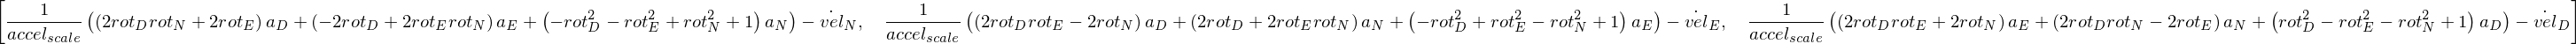

In [5]:
trans_kin_eqs = list((a_n.express(frame_i)/accel_scale - v_i.diff(t, frame_i)).to_matrix(frame_i))
trans_kin_eqs

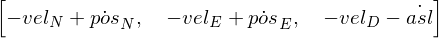

In [6]:
nav_eqs = list((p_i.diff(t, frame_i) - v_i).to_matrix(frame_i))
nav_eqs

In [7]:
sub_q = {
    (1 + rot_N**2 + rot_E**2 + rot_D**2): 1,
    2*(1 + rot_N**2 + rot_E**2 + rot_D**2): 2
}

In [8]:
rot_kin_eqs = list((frame_n.ang_vel_in(frame_i) - omega_in_n).to_matrix(frame_n))
rot_kin_eqs

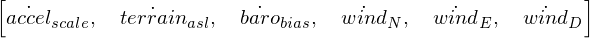

In [9]:
static_eqs = [
    accel_scale.diff(t),
    terrain_asl.diff(t),
    baro_bias.diff(t),
    wind_N.diff(t),
    wind_E.diff(t),
    wind_D.diff(t)
]
static_eqs

In [10]:
gyro_eqs = list((omega_in_n.diff(t, frame_n) - frame_i.ang_vel_in(frame_n).cross(I_w_n)).to_matrix(frame_n))
gyro_eqs

In [11]:
sol = sympy.solve(rot_kin_eqs + trans_kin_eqs + static_eqs + nav_eqs + gyro_eqs, xe.diff(t))
sol = { key:sol[key].subs(sub_q) for key in sol.keys() }
xe_dot = sympy.Matrix([ sol[var] for var in xe.diff(t) ]).applyfunc(lambda x: x.subs(sub_q))
#xe_dot

In [12]:
A = xe_dot.jacobian(xe).subs(sub_lin)
#A

In [13]:
matrix_to_code('A', A, 'Xe::', xe, 'Xe::', xe)

Matrix<float, Xe::n, Xe::n> A;
float x0 = a_D;
float x1 = accel_scale;
float x2 = 2/x1;
float x3 = x0*x2;
float x4 = a_E;
float x5 = x2*x4;
float x6 = a_N;
float x7 = x1**(-2);
float x8 = x2*x6;
float x9 = I_wz;
float x10 = I_wy;
float x11 = I_wx;
A(Xe::rot_N, Xe::gyro_bias_N) = -1/2;
A(Xe::rot_E, Xe::gyro_bias_E) = -1/2;
A(Xe::rot_D, Xe::gyro_bias_D) = -1/2;
A(Xe::vel_N, Xe::rot_E) = x3;
A(Xe::vel_N, Xe::rot_D) = -x5;
A(Xe::vel_N, Xe::accel_scale) = -x6*x7;
A(Xe::vel_E, Xe::rot_N) = -x3;
A(Xe::vel_E, Xe::rot_D) = x8;
A(Xe::vel_E, Xe::accel_scale) = -x4*x7;
A(Xe::vel_D, Xe::rot_N) = x5;
A(Xe::vel_D, Xe::rot_E) = -x8;
A(Xe::vel_D, Xe::accel_scale) = -x0*x7;
A(Xe::gyro_bias_N, Xe::gyro_bias_E) = -x9;
A(Xe::gyro_bias_N, Xe::gyro_bias_D) = x10;
A(Xe::gyro_bias_E, Xe::gyro_bias_N) = x9;
A(Xe::gyro_bias_E, Xe::gyro_bias_D) = -x11;
A(Xe::gyro_bias_D, Xe::gyro_bias_N) = -x10;
A(Xe::gyro_bias_D, Xe::gyro_bias_E) = x11;
A(Xe::pos_N, Xe::vel_N) = 1;
A(Xe::pos_E, Xe::vel_E) = 1;
A(Xe::asl, Xe::vel

## Airspeed

In [14]:
wind_i = wind_N*frame_i.x + wind_E*frame_i.y + wind_D*frame_i.z
vel_i = vel_N*frame_i.x + vel_E*frame_i.y + vel_D*frame_i.z

In [15]:
rel_wind = wind_i - vel_i
y_airspeed = sympy.Matrix([rel_wind.dot(-frame_b.x)]).subs(sub_C_nb)
y_airspeed

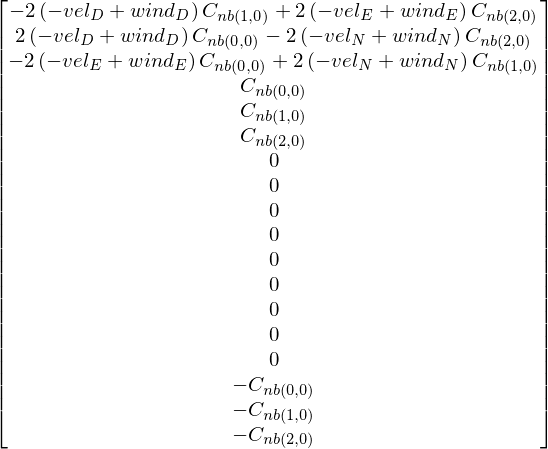

In [16]:
H_airspeed = y_airspeed.jacobian(xe).subs(sub_lin)
H_airspeed.T

In [17]:
matrix_to_code('H', H_airspeed,
               'Y_airspeed::', [sympy.Symbol('airspeed')],
               'Xe::', xe)

Matrix<float, Y_airspeed::n, Xe::n> H;
float x0 = C_nb(1, 0);
float x1 = 2*vel_D - 2*wind_D;
float x2 = C_nb(2, 0);
float x3 = 2*vel_E - 2*wind_E;
float x4 = C_nb(0, 0);
float x5 = 2*vel_N - 2*wind_N;
H(Y_airspeed::airspeed, Xe::rot_N) = x0*x1 - x2*x3;
H(Y_airspeed::airspeed, Xe::rot_E) = -x1*x4 + x2*x5;
H(Y_airspeed::airspeed, Xe::rot_D) = -x0*x5 + x3*x4;
H(Y_airspeed::airspeed, Xe::vel_N) = x4;
H(Y_airspeed::airspeed, Xe::vel_E) = x0;
H(Y_airspeed::airspeed, Xe::vel_D) = x2;
H(Y_airspeed::airspeed, Xe::wind_N) = -x4;
H(Y_airspeed::airspeed, Xe::wind_E) = -x0;
H(Y_airspeed::airspeed, Xe::wind_D) = -x2;


## Distance

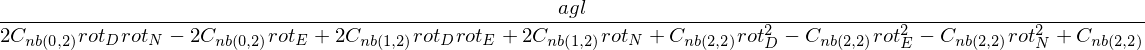

In [18]:
d_eq = sympy.solve((d*frame_b.z).dot(frame_i.z).subs(sub_C_nb) - (asl - terrain_asl), d)[0]
d_eq.subs(sub_agl)

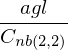

In [19]:
y_dist = sympy.Matrix([d_eq]).subs(sub_C_nb)
y_dist[0].subs(sub_lin).subs(sub_agl)

In [20]:
xe.T

In [21]:
H_distance = y_dist.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_distance.T
matrix_to_code('H', H_distance, 'Y_distance_down::',
               [sympy.symbols('d')], 'Xe::', xe)

Matrix<float, Y_distance_down::n, Xe::n> H;
float x0 = C_nb(2, 2);
float x1 = 2*agl/x0**2;
float x2 = 1/x0;
H(Y_distance_down::d, Xe::rot_N) = -x1*C_nb(1, 2);
H(Y_distance_down::d, Xe::rot_E) = x1*C_nb(0, 2);
H(Y_distance_down::d, Xe::asl) = x2;
H(Y_distance_down::d, Xe::terrain_asl) = -x2;


## Optical Flow

In [22]:
y_flow_sym = [flowX, flowY]
omega_b = (omega_ib_b - gyro_bias_i).express(frame_b)

In [23]:
vel_f_b = -vel_i - omega_b.cross(d_eq*frame_b.z)
y_flow = sympy.Matrix([
    vel_f_b.dot(frame_b.x)/d_eq,
    vel_f_b.dot(frame_b.y)/d_eq,
    ]).subs(sub_C_nb)

In [24]:
y_flow_lin = y_flow.subs(sub_lin).subs(sub_agl).subs(sub_C_nb)
y_flow_lin.simplify()
matrix_to_code('y_flow_lin', y_flow_lin, 'Y_flow::', y_flow_sym, 'Xe::', xe)

Matrix<float, Y_flow::n, Xe::n> y_flow_lin;
float x0 = agl;
float x1 = 1/x0;
float x2 = C_nb(2, 2);
float x3 = vel_N;
float x4 = vel_E;
float x5 = vel_D;
y_flow_lin(Y_flow::flowX, Xe::rot_N) = -x1*(x0*omega_by + x2*(x3*C_nb(0, 0) + x4*C_nb(1, 0) + x5*C_nb(2, 0)));
y_flow_lin(Y_flow::flowY, Xe::rot_N) = x1*(x0*omega_bx - x2*(x3*C_nb(0, 1) + x4*C_nb(1, 1) + x5*C_nb(2, 1)));


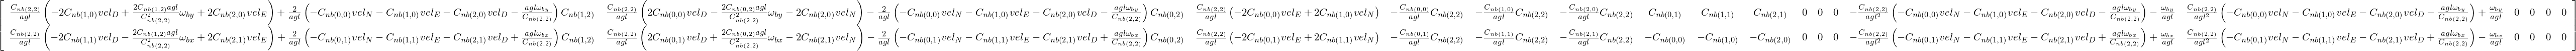

In [25]:
H_flow = y_flow.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_flow

In [26]:
P = sympy.diag(*[sympy.Symbol('var_' + str(xi)) for xi in xe])
R = sympy.diag(*[flowX, flowY])
#P = sympy.MatrixSymbol('P', len(xe), len(xe))
#R = sympy.MatrixSymbol('R', 2, 2)
S = H_flow * P * H_flow.T + R
S.simplify()

In [27]:
matrix_to_code('S', sympy.diag(S[0,0]), 'Y_flow::', y_flow_sym, 'Y_flow::', y_flow_sym,)

Matrix<float, Y_flow::n, Y_flow::n> S;
float x0 = C_nb(2, 2);
float x1 = x0**2;
float x2 = agl;
float x3 = x2**4;
float x4 = x0**4;
float x5 = C_nb(0, 0);
float x6 = vel_N;
float x7 = C_nb(1, 0);
float x8 = vel_E;
float x9 = C_nb(2, 0);
float x10 = vel_D;
float x11 = x10*x9 + x5*x6 + x7*x8;
float x12 = x2**2;
float x13 = C_nb(0, 2);
float x14 = x2*omega_by;
float x15 = x0*x11 + x14;
float x16 = C_nb(1, 2);
S(Y_flow::flowX, Y_flow::flowX) = (x1*x3*(var_gyro_bias_D*C_nb(2, 1)**2 + var_gyro_bias_E*C_nb(1, 1)**2 + var_gyro_bias_N*C_nb(0, 1)**2 + flowX) + x11**2*x4*(var_asl + var_terrain_asl) + x12*x4*(4*var_rot_D*(x5*x8 - x6*x7)**2 + var_vel_D*x9**2 + var_vel_E*x7**2 + var_vel_N*x5**2) + 4*x12*(var_rot_E*(x1*(x10*x5 - x6*x9) - x13*x14 + x13*x15)**2 + var_rot_N*(x1*(x10*x7 - x8*x9) - x14*x16 + x15*x16)**2))/(x1*x3);


In [28]:
matrix_to_code('H', H_flow, 'Y_flow::', y_flow_sym, 'Xe::', xe)

Matrix<float, Y_flow::n, Xe::n> H;
float x0 = agl;
float x1 = 1/x0;
float x2 = 2*C_nb(1, 2);
float x3 = C_nb(0, 0);
float x4 = vel_N;
float x5 = x3*x4;
float x6 = C_nb(1, 0);
float x7 = vel_E;
float x8 = x6*x7;
float x9 = C_nb(2, 2);
float x10 = vel_D;
float x11 = 2*x10*x9;
float x12 = C_nb(2, 0);
float x13 = x10*x12;
float x14 = 2*x7*x9;
float x15 = 2*x1;
float x16 = C_nb(0, 2);
float x17 = x10*x9;
float x18 = x4*x9;
float x19 = 2*x1*x9;
float x20 = x1*x9;
float x21 = C_nb(0, 1);
float x22 = C_nb(1, 1);
float x23 = C_nb(2, 1);
float x24 = x9/x0**2;
float x25 = x24*(x13 + x5 + x8);
float x26 = x21*x4;
float x27 = x22*x7;
float x28 = x10*x23;
float x29 = x24*(x26 + x27 + x28);
H(Y_flow::flowX, Xe::rot_N) = x1*(-x11*x6 + x12*x14 - x13*x2 - x2*x5 - x2*x8);
H(Y_flow::flowX, Xe::rot_E) = x15*(-x12*x18 + x13*x16 + x16*x5 + x16*x8 + x17*x3);
H(Y_flow::flowX, Xe::rot_D) = -x19*(x3*x7 - x4*x6);
H(Y_flow::flowX, Xe::vel_N) = -x20*x3;
H(Y_flow::flowX, Xe::vel_E) = -x20*x6;
H(Y_flow::flowX, Xe::ve

## Attitude

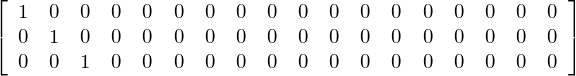

In [29]:
y_attitude = sympy.Matrix([
        rot_N, rot_E, rot_D
    ])
H_attitude = y_attitude.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_attitude